# 4km WRF Simulation of Current Climate over South America by SAAG: diagnostic plots

### Input Data Access

- This notebook illustrates how to make diagnostic plots using the dataset produced by the South America Affinity Group (SAAG) hosted on NCAR's glade storage.
- https://rda.ucar.edu/datasets/d616000/#
- This data is open access and can be accessed via 3 protocols
    1) posix (if you have access to NCAR's HPC systems)
    2) HTTPS or
    3) OSDF using an intake-ESM catalog.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import fsspec.implementations.http as fshttp
# from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
cat_url     = '/glade/campaign/collections/rda/data/d616000/catalogs/d616000_catalog.json'
print(cat_url)

/glade/campaign/collections/rda/data/d616000/catalogs/d616000_catalog.json


## Create a PBS cluster

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '10GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

client = Client(cluster)

2025-04-25 16:51:29,923 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55b5609078f27c77216631bfbe0bf2a5', 0, 0): 'waiting', ('getitem-5afc09736571825ebf9bd5e79b85d5e5', 1, 1): 'memory', ('getitem-3853275b475b9c903db9388e9fbf2f49',): 'waiting'}


In [6]:
# Scale the cluster and display cluster dashboard URL
n_workers = 5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(89c5c44d, 'tcp://128.117.208.97:39913', workers=5, threads=5, memory=50.00 GiB)

## Load SAAG data from RDA using an intake catalog

In [7]:
col = intake.open_esm_datastore(cat_url)
col

,unique
path,44
variable,214
format,1
short_name,214
long_name,97
units,26
start_time,22
end_time,44
level,0
level_units,0


## Select data and plot

### Temperature
- Plot temperature for a random date

In [8]:
cat_temp = col.search(variable='T2')
cat_temp.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d616000/k...,T2,reference,T2,NaN,K,1999-12-31,1999-12-31 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d616000/k...,T2,reference,T2,NaN,K,2000-01-01,2000-12-31 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d616000/k...,T2,reference,T2,NaN,K,2001-01-01,2001-12-31 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d616000/k...,T2,reference,T2,NaN,K,2002-01-01,2002-12-31 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d616000/k...,T2,reference,T2,NaN,K,2003-01-01,2003-12-31 23:00:00,NaN,NaN,0 days 01:00:00


- The data is organized in (virtual) zarr stores with one water year's worth of data in one file
- Select a year


In [9]:
date = "2020-01-01"
# year = "2021"
cat_temp_subset = cat_temp.search(start_time = date)
cat_temp_subset

,unique
path,1
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,1
end_time,1
level,0
level_units,0


### Load data into xarray

In [10]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = cat_temp_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



Dataset dictionary keys:
 dict_keys(['T2.T2'])


In [11]:
# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
# store_name = dataset_key + ".zarr"
print(dsets.keys())
ds = dsets[dataset_key]
ds = ds.T2
ds

dict_keys(['T2.T2'])


<xarray.DataArray 'T2' (Time: 8784, south_north: 2027, west_east: 1471)> Size: 105GB
dask.array<open_dataset-T2, shape=(8784, 2027, 1471), dtype=float32, chunksize=(1, 1014, 736), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
    XLAT     (Time, south_north, west_east) float32 105GB dask.array<chunksize=(1, 1014, 736), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 105GB dask.array<chunksize=(1, 1014, 736), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 70kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

In [12]:
%%time
desired_date = "2020-10-01"
ds_subset = ds.sel(Time=desired_date,method='nearest')
ds_subset

CPU times: user 4.28 ms, sys: 3.34 ms, total: 7.62 ms
Wall time: 12.3 ms


<xarray.DataArray 'T2' (south_north: 2027, west_east: 1471)> Size: 12MB
dask.array<getitem, shape=(2027, 1471), dtype=float32, chunksize=(1014, 736), chunktype=numpy.ndarray>
Coordinates:
    Time     datetime64[ns] 8B 2020-10-01
    XLAT     (south_north, west_east) float32 12MB dask.array<chunksize=(1014, 736), meta=np.ndarray>
    XLONG    (south_north, west_east) float32 12MB dask.array<chunksize=(1014, 736), meta=np.ndarray>
    XTIME    datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

CPU times: user 28 s, sys: 36.4 s, total: 1min 4s
Wall time: 6min 21s


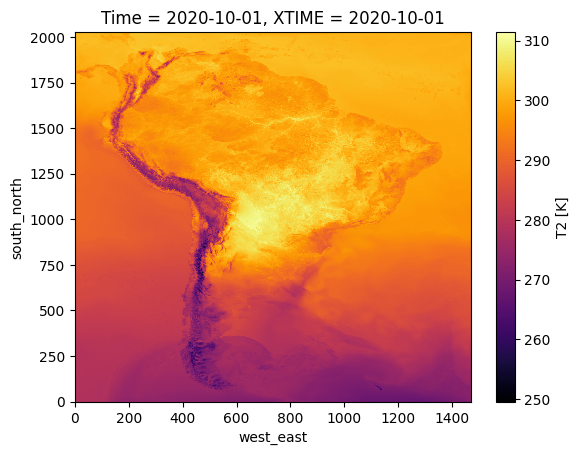

In [13]:
%%time
ds_subset.plot(cmap='inferno')

In [14]:
cluster.close()